# this notebooks shows an example of generating building blocks from a list of smiles

In [11]:
import itertools
from rdkit.Chem import rdMolDescriptors
from rdkit import Chem
import pandas as pd
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
import os
os.chdir('/rds/general/user/ma11115/home/STK_Search/STK_search')

In [12]:
# helper function to define building blocks from fragments
def fragment_from_smiles(smile):
    mol2=Chem.MolFromSmiles(smile)
    mol2=Chem.AddHs(mol2)
    if rdMolDescriptors.CalcNumAromaticRings(mol2)>6:
        return [],[],[]
    if mol2.GetNumAtoms()>40:
        return [],[],[]
    potential_connection=[]
    for x in mol2.GetAtoms():
        #print(x.GetIdx(), x.GetHybridization())
        if x.GetAtomicNum() == 35 or x.GetAtomicNum() == 34 or x.GetAtomicNum() == 17:
            return [],[],[]
        if x.GetAtomicNum() == 6 and x.GetHybridization().name == 'SP2':
            for atom in x.GetNeighbors():
                if atom.GetAtomicNum() == 1:
                    potential_connection.append(atom.GetIdx())#atom.SetAtomicNum(35)
    mol_list = []
    mol_list_smiles=[]
    potential_connection=list(set(potential_connection))
    #print(potential_connection)
    #print(len(set(itertools.combinations(potential_connection, 2))))
    for atom1,atom2 in set(itertools.combinations(potential_connection, 2)):
        mol_trans=Chem.Mol(mol2)
        
        pass_case=False
        Neighbour_atom1 = mol_trans.GetAtoms()[atom1].GetNeighbors()
        Neighbour_atom2 = mol_trans.GetAtoms()[atom2].GetNeighbors()
        for atom1_N in Neighbour_atom1:
            for atom2_N in Neighbour_atom2:
                if atom1_N.GetIdx() == atom2_N.GetIdx():
                    pass_case=True
                    break
                if atom1_N.GetIdx() in [x.GetIdx() for x in atom2_N.GetNeighbors()]:
                    pass_case=True
                    break
                if len(set([x.GetIdx() for x in atom1_N.GetNeighbors()])\
                    .intersection(set([x.GetIdx() for x in atom2_N.GetNeighbors()])))>0:
                  #  print(len(set([x.GetIdx() for x in atom1_N.GetNeighbors()])\
                  #.intersection(set([x.GetIdx() for x in atom2_N.GetNeighbors()])))>0)
                    pass_case=True
                    break
        if pass_case:
            continue
        mol_trans.GetAtoms()[atom1].SetAtomicNum(35)
        mol_trans.GetAtoms()[atom2].SetAtomicNum(35)
        mol_list.append(mol_trans)
        mol_list_smiles.append(Chem.MolToSmiles(mol_trans))
    return mol_list,mol_list_smiles, [smile]

In [13]:
# load a dataframe with a list of fragments as smiles
df_unit_polymer=pd.read_csv('data/input/classification_unit_A_or_D.csv')
df_unit_polymer.head()

,Unnamed: 0,fragment_number,smi_filename,smiles,sTDDFTxtb_HOMO,B3LYP_HOMO,A_or_D
0,0,0,0_TL.smi,C(=C1C(=O)c2cc(F)c(F)cc2C1=C(C#N)C#N),-16.456,-7.491072,A
1,1,1,1_TL.smi,C(=C1C(=O)c2ccccc2C1=C(C#N)C#N),-16.284,-7.364308,A
2,2,10,10_TL.smi,C(=C1C(=O)N(CC)C(=S)N(CC)C1=O),-14.764,-6.244068,D
3,3,100,100_C.smi,c1cc2C(CC)(CC)c3c(-c2cc1)ccc(c3),-15.072,-6.471064,D
4,4,101,101_C.smi,c1cc2C(=O)NC(=O)c3cc(cc(c1)c23),-15.743,-6.965591,A


737
453
161


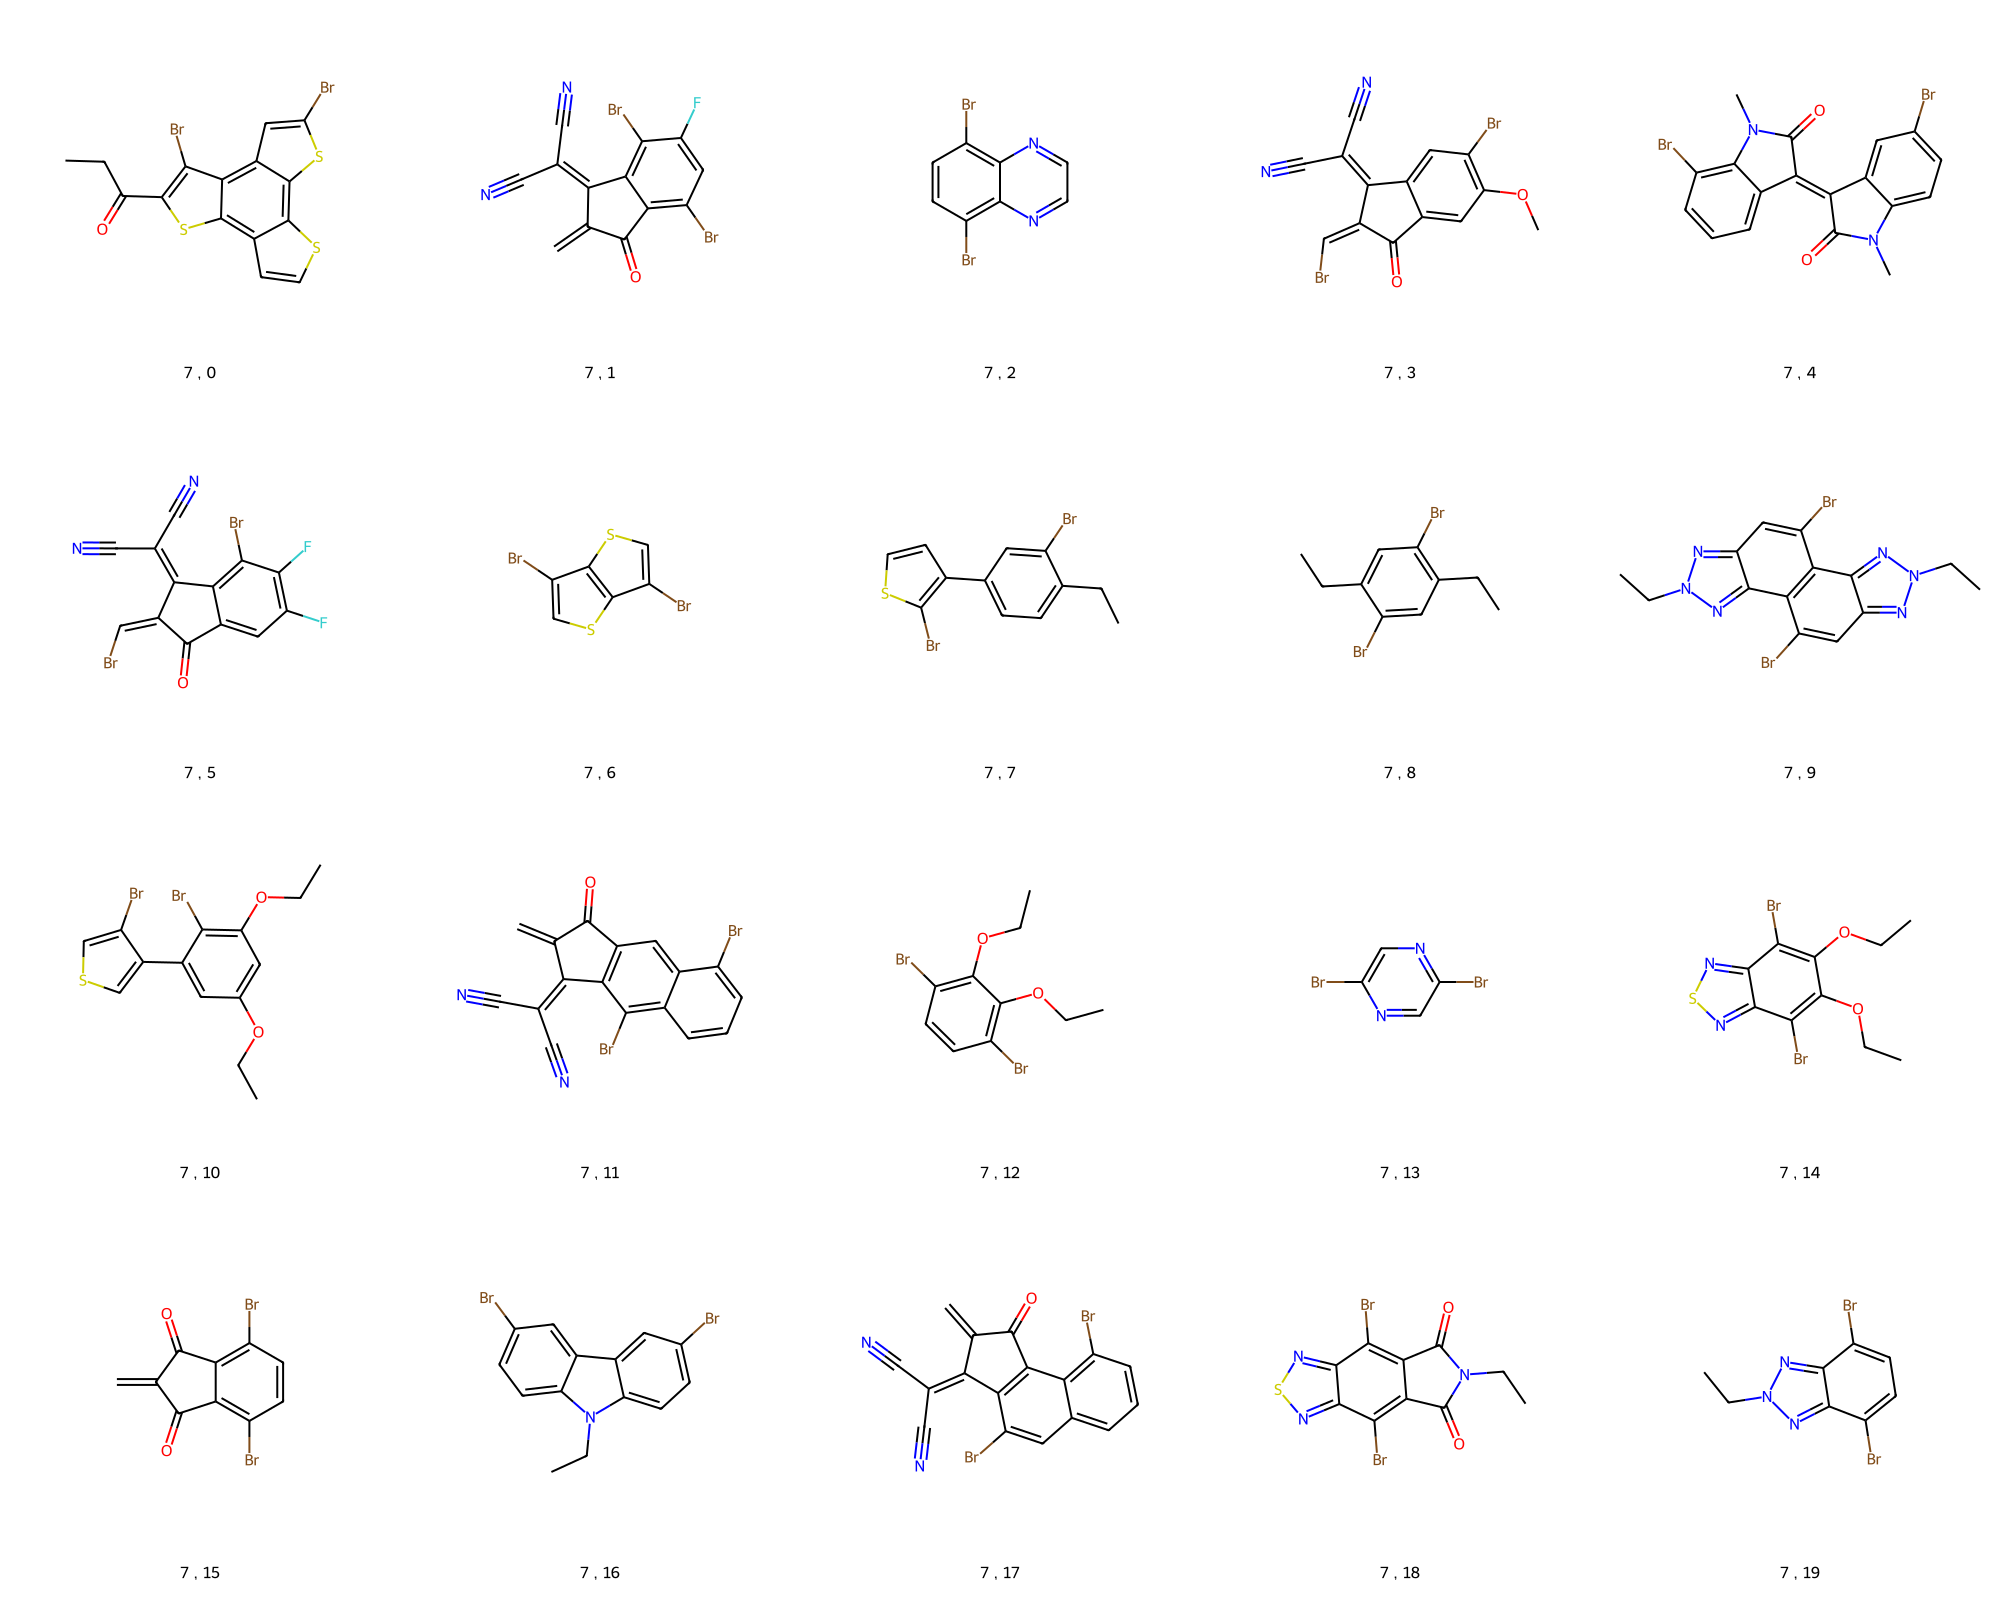

In [14]:
mol_list_smiles_all=[]
mol_list_all=[]
org_smiles=[]

for count,smiles in enumerate(df_unit_polymer['smiles']):
    mol=Chem.MolFromSmiles(smiles)
    if mol.GetNumAtoms()<30:
        mol_list,mol_list_smiles,smile=fragment_from_smiles(smiles)
        mol_list_smiles_all+=mol_list_smiles
        mol_list_all+=mol_list
        org_smiles+=smile

    #if count>12:
     #   break
print(len(mol_list_smiles_all))
mol_list_all = [Chem.MolFromSmiles(smile) for smile in set(mol_list_smiles_all)]
mol_list_all_org = [Chem.MolFromSmiles(smile) for smile in set(org_smiles)]
print(len(set(mol_list_smiles_all)))
print(len(set(org_smiles)))
img=Draw.MolsToGridImage(mol_list_all[:20],molsPerRow=5,subImgSize=(400,400),returnPNG=False,legends=[f"7 , {index}" for index, x in enumerate(mol_list_all)])    
img


In [15]:
# save a list of smiles into a file
with open('data/input/fragementclean_1005.txt', 'w') as f:
    for item in set(mol_list_smiles_all):
        f.write("%s\n" % item)

## calculate the properties of for the building blocks and add them to the database
 this part is necessary to add the building block to the molecules database, so that we can load the building blocks to build the oligomers from there

In [88]:

from stk_search.utils import Precursor_calculation
import importlib
importlib.reload(Precursor_calculation)
calculator = Precursor_calculation.Calculate_Precursor()
calculator.client = "mongodb://ch-atarzia.ch.ic.ac.uk/"
calculator.db_mol = 'stk_mohammed_precursor' # name of the molecules database
# these paths need to be adapted for your environment
calculator.xtb_path = (
            "/rds/general/user/ma11115/home/anaconda3/envs/ML/bin/xtb"
        )
calculator.STDA_bin_path = (
    "/rds/general/user/ma11115/home/bin/stda_files/xtb4stda/"
)
calculator.Db_folder = (
    "/rds/general/ephemeral/user/ma11115/ephemeral/BO_precursor"
)
os.makedirs(calculator.Db_folder, exist_ok=True)
calculator.host_IP = "cx1"
calculator.collection_name = "Precursors"




In [115]:
for smiles in mol_list_smiles_all:
    ES1 = calculator.evaluate_element(smiles)
    print(ES1)

(3.787, 'GVYASUPVXDSGHN-UQCOIBPSSA-N')
(3.787, 'GVYASUPVXDSGHN-UQCOIBPSSA-N')
(3.514, 'HNRHIGPDSSXEJA-FARCUNLSSA-N')
(3.514, 'HNRHIGPDSSXEJA-FARCUNLSSA-N')
(3.414, 'SNMJIXVGAOBXCS-UHFFFAOYSA-N')
(3.364, 'LWMBLJLODRWDDF-NYYWCZLTSA-N')
(3.342, 'BJFIUKSBVAJFOJ-WTKPLQERSA-N')
(3.364, 'LWMBLJLODRWDDF-NYYWCZLTSA-N')
(3.349, 'DBEZSHISDJHLRT-NYYWCZLTSA-N')
(3.349, 'DBEZSHISDJHLRT-NYYWCZLTSA-N')
(3.342, 'BJFIUKSBVAJFOJ-WTKPLQERSA-N')
(3.74, 'BRCXVAWJTKFNPS-WTKPLQERSA-N')
(3.367, 'JKHLXJQXMRYOIR-UHFFFAOYSA-N')
(3.74, 'BRCXVAWJTKFNPS-WTKPLQERSA-N')
(4.61, 'YRLHTVUVZGUJFJ-UHFFFAOYSA-N')
(4.61, 'YRLHTVUVZGUJFJ-UHFFFAOYSA-N')
(4.603, 'XHNZXCWTYWLMSA-UHFFFAOYSA-N')
(4.613, 'TYECWABMXAYFSG-UHFFFAOYSA-N')
(4.605, 'FUEMRLNZYZSYAL-UHFFFAOYSA-N')
(4.625, 'FVMLVXOVCFAVOY-UHFFFAOYSA-N')
(4.634, 'SCLMRBWNFRQGIQ-UHFFFAOYSA-N')
(4.613, 'UQNPYIQHMRTHET-UHFFFAOYSA-N')
(4.423, 'JOQLSILWMLVPTL-UHFFFAOYSA-N')
(4.603, 'XHNZXCWTYWLMSA-UHFFFAOYSA-N')
(4.599, 'TTZBPWNRCSNKSN-UHFFFAOYSA-N')
(4.616, 'NCUNXZGJDQPCAV-UHFFF

(3.383, 'NBFKNJVRLZRYBR-UHFFFAOYSA-N')
(3.402, 'VVAAKJMZBFEUOL-NYYWCZLTSA-N')
(3.515, 'DFVWITBQMBKXMZ-WCIBSUBMSA-N')
(3.515, 'DFVWITBQMBKXMZ-WCIBSUBMSA-N')
(3.386, 'RDCOPDHLWDNELI-BAQGIRSFSA-N')
(3.386, 'RDCOPDHLWDNELI-BAQGIRSFSA-N')
(3.381, 'DIDQMLGAQRSBFO-CLTKARDFSA-N')
(3.381, 'DIDQMLGAQRSBFO-CLTKARDFSA-N')
(3.377, 'WQANUVJHVVOIIX-OQFOIZHKSA-N')
(3.377, 'WQANUVJHVVOIIX-OQFOIZHKSA-N')
(2.131, 'DVUFXYNFUQYPQD-FOCLMDBBSA-N')
(1.939, 'OWYNXVNPNFDORT-PFONDFGASA-N')
(2.131, 'DVUFXYNFUQYPQD-FOCLMDBBSA-N')
(2.048, 'JLCRNQJKJULAEP-FYWRMAATSA-N')
(2.072, 'VDZLMWNWVUUKSD-JQIJEIRASA-N')
(2.072, 'VDZLMWNWVUUKSD-JQIJEIRASA-N')
(1.939, 'OWYNXVNPNFDORT-PFONDFGASA-N')
(1.966, 'CGUPPVSZVLTYOP-NXVVXOECSA-N')
(2.09, 'ZCEPCGSBFKIVPC-CCEZHUSRSA-N')
(1.898, 'XNAKOHTVYJUZGY-PEZBUJJGSA-N')
(2.048, 'JLCRNQJKJULAEP-FYWRMAATSA-N')
(2.041, 'NHXDMKMQMIUSQS-FYWRMAATSA-N')
(2.041, 'NHXDMKMQMIUSQS-FYWRMAATSA-N')
(1.962, 'IDBVISAUORVKGR-NXVVXOECSA-N')
(1.898, 'XNAKOHTVYJUZGY-PEZBUJJGSA-N')
(2.09, 'ZCEPCGSBFKIVPC-CCE

(3.263, 'AFEXTQKHFIGNAW-YWEYNIOJSA-N')
(3.263, 'AFEXTQKHFIGNAW-YWEYNIOJSA-N')
(3.241, 'VUFJPSZUMXWWEZ-WTKPLQERSA-N')
(3.241, 'VUFJPSZUMXWWEZ-WTKPLQERSA-N')
(3.286, 'ILVQPXHNRKDPBD-WMZJFQQLSA-N')
(3.286, 'ILVQPXHNRKDPBD-WMZJFQQLSA-N')
(3.509, 'MRBCQJMEGDDUNN-WMZJFQQLSA-N')
(3.546, 'MUDFZHJEVZULLQ-WTKPLQERSA-N')
(3.546, 'MUDFZHJEVZULLQ-WTKPLQERSA-N')
(3.471, 'CWRLVIASPCAZBH-WMZJFQQLSA-N')
(3.517, 'DIYVZAUDJBOFCF-UHFFFAOYSA-N')
(3.471, 'CWRLVIASPCAZBH-WMZJFQQLSA-N')
(3.509, 'MRBCQJMEGDDUNN-WMZJFQQLSA-N')
(3.352, 'DGNQPUBGEVNPSD-WMZJFQQLSA-N')
(3.32, 'FYQWOQJCDFUZDL-WTKPLQERSA-N')
(3.32, 'FYQWOQJCDFUZDL-WTKPLQERSA-N')
(3.474, 'RKSINUDDAYIIHH-XBXARRHUSA-N')
(3.474, 'RKSINUDDAYIIHH-XBXARRHUSA-N')
(3.352, 'DGNQPUBGEVNPSD-WMZJFQQLSA-N')
(3.433, 'OIRMKUMTANFNFQ-UHFFFAOYSA-N')
(3.425, 'IAXBWBKPJBHBMN-UHFFFAOYSA-N')
(3.716, 'YWDRXBKQRQXACM-FLCLTJNMSA-N')
(3.719, 'UZVLGNUWFKIDBV-CMUQUYFMSA-N')
(3.334, 'IOTJSNCOZVUGGD-CMUQUYFMSA-N')
(3.395, 'COJGSYDOQILRNI-WSOVNZEKSA-N')
(3.395, 'COJGSYDOQILRNI-WSO

(4.01, 'YYWQGDHGDXQMFJ-UHFFFAOYSA-N')
(3.476, 'COIPPJNXAUBFKN-UHFFFAOYSA-N')
(3.382, 'RJNSNLQCGHZNCC-UHFFFAOYSA-N')
(4.565, 'KIYKHEOWZLJZSB-UHFFFAOYSA-N')
(4.565, 'KIYKHEOWZLJZSB-UHFFFAOYSA-N')
(3.642, 'SIGAQDSGJJFBIC-UHFFFAOYSA-N')
(3.687, 'QMRQMVSXQSFGAY-UHFFFAOYSA-N')
(3.628, 'KEPNBEPTGHROGD-UHFFFAOYSA-N')
(3.642, 'SIGAQDSGJJFBIC-UHFFFAOYSA-N')
(3.605, 'PJHPSXVUGKNGQW-UHFFFAOYSA-N')
(3.564, 'OTJHPHNPSFMEKL-UHFFFAOYSA-N')
(3.767, 'VQAFMTSSCUETHA-UHFFFAOYSA-N')
(3.85, 'BHPAAVZSQLQZAM-UHFFFAOYSA-N')
(3.832, 'OHMHORGMXXGPQX-UHFFFAOYSA-N')
(3.832, 'OHMHORGMXXGPQX-UHFFFAOYSA-N')
(3.803, 'CTLQRSLFVDHMGQ-UHFFFAOYSA-N')
(4.493, 'QTRKEUXMEUDSSV-UHFFFAOYSA-N')
(4.421, 'NODDMFSCAIIESR-UHFFFAOYSA-N')
(4.518, 'SUKMCUSPTRBPPX-UHFFFAOYSA-N')
(4.493, 'QTRKEUXMEUDSSV-UHFFFAOYSA-N')
(4.46, 'YFPJMBXDMJQKCQ-UHFFFAOYSA-N')
(4.541, 'LAHRFJDDUSNBAL-UHFFFAOYSA-N')
(4.539, 'MLYRWCIHNBXFTB-UHFFFAOYSA-N')
(4.421, 'NODDMFSCAIIESR-UHFFFAOYSA-N')
(4.518, 'SUKMCUSPTRBPPX-UHFFFAOYSA-N')
(3.933, 'GBPCLLBKTPPGAY-UHFF

(4.715, 'TZONJRYYYDXYTE-UHFFFAOYSA-N')
(4.715, 'TZONJRYYYDXYTE-UHFFFAOYSA-N')
(4.598, 'BNNSWMVTQRDWJV-UHFFFAOYSA-N')
(4.845, 'LPTRCOXHGVILNO-UHFFFAOYSA-N')
(4.68, 'VUPJQGFXDJTOQS-UHFFFAOYSA-N')
(4.76, 'JABFDNUJYHHKFP-UHFFFAOYSA-N')
(4.76, 'JABFDNUJYHHKFP-UHFFFAOYSA-N')
(4.665, 'RZKKTHJJSTTZNI-UHFFFAOYSA-N')
(4.831, 'CRKOXSSRSUFLHZ-UHFFFAOYSA-N')
(4.845, 'LPTRCOXHGVILNO-UHFFFAOYSA-N')
(4.665, 'RZKKTHJJSTTZNI-UHFFFAOYSA-N')
(4.598, 'BNNSWMVTQRDWJV-UHFFFAOYSA-N')
(4.831, 'CRKOXSSRSUFLHZ-UHFFFAOYSA-N')
(4.056, 'DSTKSVOQKUHOLG-UHFFFAOYSA-N')
(4.008, 'SJXHQUBNLYQDRD-UHFFFAOYSA-N')
(4.016, 'UBDUZEIOGICXGR-UHFFFAOYSA-N')
(3.718, 'VWWZUHXNTZKHIV-UHFFFAOYSA-N')
(3.798, 'MJADAOQOMXCRGL-UHFFFAOYSA-N')
(3.798, 'MJADAOQOMXCRGL-UHFFFAOYSA-N')
(3.765, 'JNKFRUGPPVTXCU-UHFFFAOYSA-N')
(3.718, 'VWWZUHXNTZKHIV-UHFFFAOYSA-N')
(3.662, 'TXPOJOPJEYLJSF-UHFFFAOYSA-N')
(3.512, 'BWKDZACSILBJLI-UHFFFAOYSA-N')
(3.564, 'LBUQBGYGLNLYOI-UHFFFAOYSA-N')
(3.468, 'PAICQYQDRZLVIQ-UHFFFAOYSA-N')
(3.512, 'BWKDZACSILBJLI-UHFF

(3.741, 'UNOXOWXWZXWVFR-WMZJFQQLSA-N')
(3.741, 'UNOXOWXWZXWVFR-WMZJFQQLSA-N')
(3.471, 'GVFOIZUZDTYVQB-ONNFQVAWSA-N')
(3.471, 'GVFOIZUZDTYVQB-ONNFQVAWSA-N')
(3.465, 'IRFKMWOOGZDSLV-LZCJLJQNSA-N')


(3.506, 'GQAKHAGRFCGGAT-BHQIHCQQSA-N')
(3.506, 'GQAKHAGRFCGGAT-BHQIHCQQSA-N')
(3.465, 'IRFKMWOOGZDSLV-LZCJLJQNSA-N')
(3.675, 'HYBYCPVCLBFVIW-UHFFFAOYSA-N')
(3.718, 'GCWFFIBCPDJBQK-UHFFFAOYSA-N')
(3.633, 'WRPMDPUCVPTOJX-UHFFFAOYSA-N')
(3.675, 'HYBYCPVCLBFVIW-UHFFFAOYSA-N')
(3.963, 'DDQMXMOHGMNKLP-UHFFFAOYSA-N')
(3.799, 'XZXYPNZEWNZGOF-UHFFFAOYSA-N')
(3.839, 'IZNMTFHYZDELHX-UHFFFAOYSA-N')
(3.833, 'RBRIKJSISCDOLM-UHFFFAOYSA-N')
(3.809, 'HALNBKCJYKNSQV-UHFFFAOYSA-N')
(3.821, 'XORWEKRDQCXPID-UHFFFAOYSA-N')
(3.799, 'XZXYPNZEWNZGOF-UHFFFAOYSA-N')
(3.821, 'XORWEKRDQCXPID-UHFFFAOYSA-N')
(3.839, 'IZNMTFHYZDELHX-UHFFFAOYSA-N')
(4.424, 'HFUBKQHDPJZQIW-UHFFFAOYSA-N')
(4.362, 'MSUPZGGVRIRXAI-UHFFFAOYSA-N')
(4.443, 'FEOWHLLJXAECMU-UHFFFAOYSA-N')
(4.658, 'AJKFTLSGAAURDT-UHFFFAOYSA-N')


(4.127, 'HZYBLPHGWLNIQV-UHFFFAOYSA-N')
(3.634, 'PDACWRNFXCJINA-VZUCSPMQSA-N')
(3.654, 'KBJMXLISRUFBPE-VZUCSPMQSA-N')
(3.736, 'BJFHVTCUUWLZMZ-UHFFFAOYSA-N')
(3.634, 'PDACWRNFXCJINA-VZUCSPMQSA-N')
(3.654, 'KBJMXLISRUFBPE-VZUCSPMQSA-N')
(3.64, 'XPFYDVCODIQSMF-VZUCSPMQSA-N')
(3.736, 'BJFHVTCUUWLZMZ-UHFFFAOYSA-N')
(3.634, 'PDACWRNFXCJINA-VZUCSPMQSA-N')
(3.654, 'KBJMXLISRUFBPE-VZUCSPMQSA-N')
(3.634, 'PDACWRNFXCJINA-VZUCSPMQSA-N')
(3.654, 'KBJMXLISRUFBPE-VZUCSPMQSA-N')
(3.64, 'XPFYDVCODIQSMF-VZUCSPMQSA-N')
(3.701, 'GHVKQKSSDWWNPV-UHFFFAOYSA-N')


(3.675, 'YIIYTYPIDSFUCV-XGICHPGQSA-N')
(3.625, 'UWIPGJNYCOMXAL-XGICHPGQSA-N')
(3.625, 'UWIPGJNYCOMXAL-XGICHPGQSA-N')
(3.675, 'YIIYTYPIDSFUCV-XGICHPGQSA-N')
(3.572, 'WICLOIWVEHRNDR-LFYBBSHMSA-N')
(3.675, 'YIIYTYPIDSFUCV-XGICHPGQSA-N')
(3.625, 'UWIPGJNYCOMXAL-XGICHPGQSA-N')
(3.625, 'UWIPGJNYCOMXAL-XGICHPGQSA-N')
(3.675, 'YIIYTYPIDSFUCV-XGICHPGQSA-N')
(3.701, 'GHVKQKSSDWWNPV-UHFFFAOYSA-N')
(3.572, 'WICLOIWVEHRNDR-LFYBBSHMSA-N')
(3.772, 'WNFLYQKNPCWEHM-OQFOIZHKSA-N')
(3.772, 'WNFLYQKNPCWEHM-OQFOIZHKSA-N')
(3.785, 'PQZAHLJJGPAGBD-OQFOIZHKSA-N')
(3.785, 'PQZAHLJJGPAGBD-OQFOIZHKSA-N')


(3.697, 'VZFRQAYOJWWGBK-BAQGIRSFSA-N')
(3.697, 'VZFRQAYOJWWGBK-BAQGIRSFSA-N')
(3.445, 'MATVSQOKVLAMKO-UHFFFAOYSA-N')
(4.384, 'TWZPWMNAQFXRCD-UHFFFAOYSA-N')
(4.384, 'TWZPWMNAQFXRCD-UHFFFAOYSA-N')
(3.98, 'DKXMNPIIOQYICL-UHFFFAOYSA-N')
(3.312, 'HEDSSLGMKSEYIJ-OQFOIZHKSA-N')
(3.486, 'KVVQGJGZUYZXLC-UHFFFAOYSA-N')
(3.467, 'YVSPTJVUUCQLDV-YCRREMRBSA-N')
(3.742, 'DSQLOQBIMTUVTG-BAQGIRSFSA-N')
(3.312, 'HEDSSLGMKSEYIJ-OQFOIZHKSA-N')
(3.742, 'DSQLOQBIMTUVTG-BAQGIRSFSA-N')
(3.467, 'YVSPTJVUUCQLDV-YCRREMRBSA-N')
(3.745, 'RTHCZUJRUPXMTF-WCIBSUBMSA-N')


(3.368, 'VRPZYCVDWIOLDA-UHFFFAOYSA-N')
(3.453, 'GNDULBQJLKQFNV-ONNFQVAWSA-N')


(3.736, 'BSBUYWIGXQBMGH-WMZJFQQLSA-N')
(3.745, 'RTHCZUJRUPXMTF-WCIBSUBMSA-N')
(3.736, 'BSBUYWIGXQBMGH-WMZJFQQLSA-N')
(3.453, 'GNDULBQJLKQFNV-ONNFQVAWSA-N')


(3.716, 'HMJCEQVRXHOJDX-WCIBSUBMSA-N')
(3.333, 'PWTUWGJJVGKWSL-UHFFFAOYSA-N')
(3.577, 'ITWOUVVCPPUABP-WCIBSUBMSA-N')
(3.705, 'JOZZEHWDCVJWBH-WMZJFQQLSA-N')
(3.716, 'HMJCEQVRXHOJDX-WCIBSUBMSA-N')
(3.705, 'JOZZEHWDCVJWBH-WMZJFQQLSA-N')
(3.577, 'ITWOUVVCPPUABP-WCIBSUBMSA-N')
(3.502, 'QPECLUUJRPOPGE-UHFFFAOYSA-N')
(3.451, 'FDAZPZADKYHVQQ-NSIKDUERSA-N')
(3.436, 'GMEPJLUCWJWLQM-MLPAPPSSSA-N')
(3.463, 'QRJCKLHPDPZSBN-NSIKDUERSA-N')
(3.48, 'DOPYWBFRCHICIA-UUASQNMZSA-N')
(3.43, 'DTWFHPUAZGGOOD-UHFFFAOYSA-N')
(3.48, 'DOPYWBFRCHICIA-UUASQNMZSA-N')
(3.521, 'OTCZRCDVDQQVEV-GIDUJCDVSA-N')
(3.436, 'GMEPJLUCWJWLQM-MLPAPPSSSA-N')
(3.453, 'UDYYMEWUBRUKGU-UHFFFAOYSA-N')


(3.181, 'HZAHDTXOZMPEEE-AWNIVKPZSA-N')
(3.47, 'QCRVYUFITBDRDO-UHFFFAOYSA-N')
(3.492, 'AJKJAHUMMXIXHL-UHFFFAOYSA-N')
(3.451, 'FDAZPZADKYHVQQ-NSIKDUERSA-N')
(3.463, 'QRJCKLHPDPZSBN-NSIKDUERSA-N')
(3.521, 'OTCZRCDVDQQVEV-GIDUJCDVSA-N')
(3.452, 'LXPGOLVTQAXCFY-UHFFFAOYSA-N')
(3.181, 'HZAHDTXOZMPEEE-AWNIVKPZSA-N')
(3.459, 'XYBMHUNGLSHXST-UHFFFAOYSA-N')
(3.443, 'NGTUECGTXMWUQR-UHFFFAOYSA-N')
(3.376, 'JQGYRMLRZCFYTH-UQCOIBPSSA-N')
(3.376, 'JQGYRMLRZCFYTH-UQCOIBPSSA-N')
(5.115, 'JVAUNSRALVFKNX-HSFFGMMNSA-N')
(5.115, 'JVAUNSRALVFKNX-HSFFGMMNSA-N')
(5.115, 'JVAUNSRALVFKNX-HSFFGMMNSA-N')
(5.115, 'JVAUNSRALVFKNX-HSFFGMMNSA-N')
(3.75, 'ZHVDMNINQUXGKD-KTAJNNJTSA-N')
(3.75, 'ZHVDMNINQUXGKD-KTAJNNJTSA-N')
(3.521, 'XHVQKAXLUXFACH-WCIBSUBMSA-N')
(3.484, 'NFBVAFLPOWUEDP-UHFFFAOYSA-N')
(3.521, 'XHVQKAXLUXFACH-WCIBSUBMSA-N')
(3.519, 'OHRVXLGYKXSESB-UUILKARUSA-N')
(3.491, 'DAWKQSTYNGDHPJ-WCIBSUBMSA-N')
(3.464, 'OOGZZPYYLMHIKP-UHFFFAOYSA-N')
(3.519, 'OHRVXLGYKXSESB-UUILKARUSA-N')
(3.523, 'JZYYSTRATMXCHG-UUIL

(3.385, 'QWNPJXIZYQXJPZ-UHFFFAOYSA-N')
(3.414, 'GRDZBQDKTFKZKN-UHFFFAOYSA-N')
(3.478, 'YDUJQBGVBMNHME-UHFFFAOYSA-N')
(3.478, 'YDUJQBGVBMNHME-UHFFFAOYSA-N')
(4.002, 'QBBBQRZWDHVSKE-UHFFFAOYSA-N')
(3.531, 'QZFMFDCTFHOXQF-UHFFFAOYSA-N')
(3.464, 'VNZOXMKPKFJIII-UHFFFAOYSA-N')
(3.552, 'WKBJSXQNMQQYDA-UHFFFAOYSA-N')
(3.382, 'XWZSMRRKAUYNMH-UHFFFAOYSA-N')
(3.44, 'BJTIKALMORNWNR-UHFFFAOYSA-N')


(3.461, 'YYTSOZXMJUHWJS-UHFFFAOYSA-N')


(3.404, 'HDLQYWLFGNHWIY-UHFFFAOYSA-N')
(3.508, 'ZYFAZQDJDGUYES-UHFFFAOYSA-N')


(3.12, 'AHMXXSJYABXTPK-ONNFQVAWSA-N')
(3.423, 'NRVIERHCWDQTBL-UHFFFAOYSA-N')
(3.12, 'AHMXXSJYABXTPK-ONNFQVAWSA-N')
(3.384, 'IKMLBUYCSKWWAR-WCIBSUBMSA-N')
(3.366, 'BHOSZUQMOQVQOO-UHFFFAOYSA-N')
(3.384, 'IKMLBUYCSKWWAR-WCIBSUBMSA-N')
(3.322, 'MTLFYGNDDYBIIU-JYOAFUTRSA-N')
(3.353, 'VADGQEXKRFNGDZ-UHFFFAOYSA-N')
(3.322, 'MTLFYGNDDYBIIU-JYOAFUTRSA-N')
(3.358, 'IIXYXVCGBSIBLJ-ONNFQVAWSA-N')
(3.351, 'ZYHVJHXGAYIDDI-UHFFFAOYSA-N')
(3.358, 'IIXYXVCGBSIBLJ-ONNFQVAWSA-N')


In [43]:
# helper function to load the data calculated for the precurosors
import pymongo
def load_data(collection_name = 'Precursors'):
        client = pymongo.MongoClient("mongodb://ch-atarzia.ch.ic.ac.uk/")
        database = client["stk_mohammed_precursor"]
        collection = database[f"{collection_name}_IPEA"]
        df_IPEA = pd.DataFrame(list(collection.find()))
        collection = database[f"{collection_name}_Stda"]
        df_STDA = pd.DataFrame(list(collection.find()))
        collection = database[f"{collection_name}_opt"]
        df_opt = pd.DataFrame(list(collection.find()))
        collection = database["molecules"]
        df_CM = pd.DataFrame(list(collection.find()))
        df_total = df_CM.merge(df_STDA, on="InChIKey", how="outer")
        df_total = df_total.merge(df_IPEA, on="InChIKey", how="outer")
        df_opt.drop(columns=["_id","total energy (au)"],inplace=True)
        df_total = df_total.merge(df_opt, on="InChIKey", how="outer")
        df_total.dropna(subset=["Excited state energy (eV)"], inplace=True)

        df_total["ES1"] = df_total["Excited state energy (eV)"].apply(
            lambda x: x[0]
        )
        df_total["fosc1"] = df_total[
            "Excited state oscillator strength"
        ].apply(lambda x: x[0])
        return df_total


In [44]:
df_precursor= load_data()
df_precursor.shape

(453, 23)

In [45]:
df_precursor[df_precursor['InChIKey_initial'] != df_precursor['InChIKey']].shape

(66, 23)

In [46]:
from rdkit.Chem import rdDetermineBonds
import stk

def Inch_to_mol(InChIKey):
    client = pymongo.MongoClient("mongodb://ch-atarzia.ch.ic.ac.uk/")
    db = stk.MoleculeMongoDb(client, database='stk_mohammed_precursor',)
    stk_mol = db.get( {"InChIKey": InChIKey})
    return stk_mol.to_rdkit_mol()

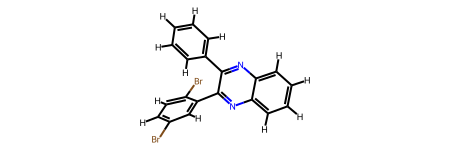

In [47]:
mol = Inch_to_mol(df_precursor['InChIKey'].iloc[0])
mol


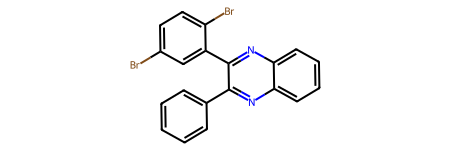

In [48]:
Chem.MolFromSmiles(Chem.MolToSmiles(mol))

# generate a df_precursor with the properties of the fragment to include in the oligomer representation

In [49]:
# case of fragment properties
numeric_columns = df_precursor.select_dtypes(include= ["int", "float"]).columns
print(numeric_columns)
df_properties = df_precursor[numeric_columns]
df_properties['InChIKey'] = df_precursor['InChIKey']
df_properties['InChIKey_initial']  = df_precursor['InChIKey_initial'] 
df_properties['mol_opt'] = df_properties['InChIKey'].apply(Inch_to_mol)
df_properties['Atom_num'] = df_properties['mol_opt'].apply(lambda x: x.GetNumAtoms())


Index(['electron affinity (eV)', 'homo lumo_gap (eV)',
       'ionisation potential (eV)', 'total energy (au)', 'HOMO-LUMO GAP (eV)',
       'ES1', 'fosc1'],
      dtype='object')


/var/tmp/pbs.9413545.pbs/ipykernel_3116900/325166140.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_properties['InChIKey'] = df_precursor['InChIKey']
/var/tmp/pbs.9413545.pbs/ipykernel_3116900/325166140.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_properties['InChIKey_initial']  = df_precursor['InChIKey_initial']
/var/tmp/pbs.9413545.pbs/ipykernel_3116900/325166140.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [50]:
df_properties[df_properties['Atom_num']<30]
def check_mol(mol):
    if mol.GetNumAtoms()>=30:
        return 0
    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() ==14:
            return 0
        if atom.GetAtomicNum() ==32:
            return 0
    return 1
df_properties['check'] = df_properties['mol_opt'].apply(check_mol)
df_properties = df_properties[df_properties['check']==1]
df_properties.drop(columns=['check'], inplace=True)
df_properties.shape

/var/tmp/pbs.9413545.pbs/ipykernel_3116900/1527244678.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_properties['check'] = df_properties['mol_opt'].apply(check_mol)


(307, 11)

In [68]:
df_properties.select_dtypes(include=[np.number]).columns

Index(['electron affinity (eV)', 'homo lumo_gap (eV)',
       'ionisation potential (eV)', 'total energy (au)', 'HOMO-LUMO GAP (eV)',
       'ES1', 'fosc1', 'Atom_num'],
      dtype='object')

In [39]:
df_properties_path = "data/input/Prescursor_data/df_properties_10052024.pkl"
os.makedirs(os.path.dirname(df_properties_path), exist_ok=True)
df_properties.to_pickle(df_properties_path)

In [107]:
# case of mordred descriptors
from mordred import Calculator, descriptors
from sklearn.decomposition import PCA
import numpy as np  

calc = Calculator(descriptors, ignore_3D=False)
df_precursor['mol_opt'] = df_precursor['InChIKey'].apply(Inch_to_mol)
descriptors_df = calc.pandas(df_precursor["mol_opt"])

descriptors_df['InChIKey'] = df_precursor["InChIKey"]
descriptors_df.dropna(inplace=True)
PCA_model = PCA(n_components=10)
frag_properties = descriptors_df.select_dtypes(include=[np.number]).columns 

X_PCA = PCA_model.fit_transform(descriptors_df[frag_properties].values)

df_representation = pd.DataFrame(X_PCA, columns=[f"PCA_{i}" for i in range(X_PCA.shape[1])])
df_representation['InChIKey'] = descriptors_df['InChIKey']

  7%|▋         | 13/179 [00:02<00:31,  5.23it/s]

[15:07:25]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-311/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****
[15:07:25]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-311/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****
[15:07:25]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-311/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****
[15:07:25]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-311/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****
[15:07:25]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-311/

 10%|█         | 18/179 [00:02<00:18,  8.91it/s]

RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-311/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****
[15:07:25]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-311/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****
[15:07:25]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-311/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****
[15:07:25]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-311/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****
[15:07:25]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-311/rdkit/Code/GraphMol/RingInfo.cpp
Failed 

 12%|█▏        | 22/179 [00:03<00:14, 11.11it/s]

Failed Expression: df_init
****
[15:07:26]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-311/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****
[15:07:26]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-311/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****
[15:07:26]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-311/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****
[15:07:26]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-311/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****
[15:07:26]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/buil

 22%|██▏       | 39/179 [00:03<00:05, 26.13it/s]

Failed Expression: df_init
****
[15:07:26]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-311/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****
[15:07:26]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-311/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****
[15:07:26]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-311/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****
[15:07:26]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-311/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****
[15:07:26]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/buil

****
[15:07:26]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-311/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****
[15:07:26]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-311/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****
[15:07:26]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-311/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****
[15:07:26]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-311/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****
[15:07:27]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython

****
[15:07:27]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-311/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****
[15:07:27]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-311/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****
[15:07:27]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-311/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****
[15:07:27]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-311/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****
[15:07:27]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython

 54%|█████▎    | 96/179 [00:03<00:01, 77.84it/s]

****
[15:07:27]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-311/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****
[15:07:27]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-311/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****
[15:07:27]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-311/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****
[15:07:27]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-311/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****
[15:07:27]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython

IOPub message rate exceeded.                     
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [108]:
df_representation_path = "data/input/Prescursor_data/df_mordred_10052024.pkl"
os.makedirs(os.path.dirname(df_representation_path), exist_ok=True)
df_representation.to_pickle(df_representation_path)